In [2]:
# Libraries
import glob, os
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import earthpy.spatial as es

### Dataset used: Level-3 MODIS/Terra 8-day composite snow Cover product MOD10A2 (https://search.earthdata.nasa.gov/search)
### The whole study area covers Four tiles of MOD10A2 product: h24v06, h24v05, h23v05, and h25v06
### Data downloaded (March 2000 to February 2020) and stored for each tile in their respective folders
### pixel values 
#### 1: no decision
#### 11: night
#### 25: no snow
#### 37: lake
#### 39: ocean
#### 50: cloud
#### 100: lake ice
#### 200: snow
#### 254: detector saturated
#### 255: fill

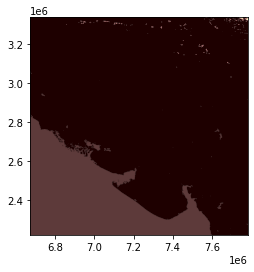

In [5]:
file1 = rasterio.open('F:/Avi_SCA/Data/h24v06/MOD10A2_A2000057_h24v06_006_2016061234204_MOD_Grid_Snow_500m_Maximum_Snow_Extent_3a399a8e.tif')
show(file1, cmap='pink')

In [15]:
h24v06 = []

os.chdir("F:/Avi_SCA/Data/h24v06")
for file in glob.glob("*.tif"):
    if file[61]=='M':
        h24v06.append(file)  

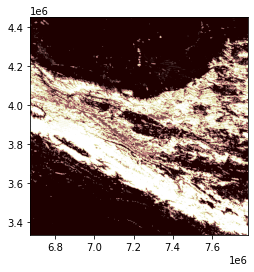

In [6]:
file1 = rasterio.open('F:/Avi_SCA/Data/h24v05/MOD10A2_A2000057_h24v05_006_2016061234203_MOD_Grid_Snow_500m_Maximum_Snow_Extent_3a2e35bd_2.tif')
show(file1, cmap='pink')

In [16]:
h24v05 = []

os.chdir("F:/Avi_SCA/Data/h24v05")
for file in glob.glob("*.tif"):
    if file[61]=='M':
        h24v05.append(file)

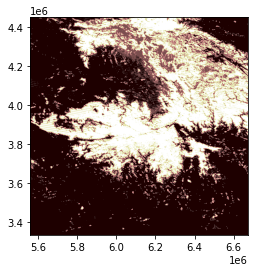

In [12]:
file1 = rasterio.open('F:/Avi_SCA/Data/h23v05/MOD10A2_A2000057_h23v05_006_2016061234159_MOD_Grid_Snow_500m_Maximum_Snow_Extent_3a200b20.tif')
show(file1, cmap='pink')

In [17]:
h23v05 = []

os.chdir("F:/Avi_SCA/Data/h23v05")
for file in glob.glob("*.tif"):
    if file[61]=='M':
        h23v05.append(file)

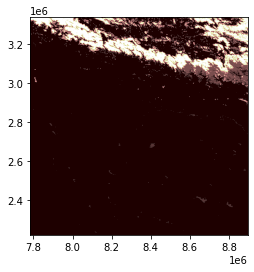

In [11]:
file1 = rasterio.open('F:/Avi_SCA/Data/h25v06/MOD10A2_A2000057_h25v06_006_2016061234205_MOD_Grid_Snow_500m_Maximum_Snow_Extent_3a2c559a.tif')
show(file1, cmap='pink')

In [18]:
h25v06 = []

os.chdir("F:/Avi_SCA/Data/h25v06")
for file in glob.glob("*.tif"):
    if file[61]=='M':
        h25v06.append(file) 

In [19]:
# collect all the days for which the snow observation is present from their filenames
days = []
for file in h24v06:
    days.append(file[9:16])
    

In [9]:
days[0:5]

['2000057', '2000065', '2000073', '2000081', '2000089']

In [10]:
# mosaic the four tiles for each day to produce a single image and saved in folder called "marged_data"
for i in range(0,len(days)):
    files_to_merge = []
    if days[i] in h24v06[i]:
        snow=rasterio.open('F:/Avi_SCA/Data/h24v06/'+h24v06[i])
        files_to_merge.append(snow)       
    if days[i] in h24v05[i]:
        snow=rasterio.open('F:/Avi_SCA/Data/h24v05/'+h24v05[i])
        files_to_merge.append(snow)
    if days[i] in h25v06[i]:
        snow=rasterio.open('F:/Avi_SCA/Data/h25v06/'+h25v06[i])
        files_to_merge.append(snow)
    if days[i] in h23v05[i]:
        snow=rasterio.open('F:/Avi_SCA/Data/h23v05/'+h23v05[i])
        files_to_merge.append(snow)
    mosaic, out_trans = merge(files_to_merge)
    # saving the mosaic with same metadata
#sample = rasterio.open('F:/Avi_SCA/Data/test_2019/monthly_mosaic/'+filenames[3])
    profile=snow.profile
    profile.update(transform = out_trans,width = mosaic.shape[2],height = mosaic.shape[1])
    os.chdir("F:/Avi_SCA/Data/marged_data")

    with rasterio.open(days[i]+'.tif', 'w', **profile) as dst:
        dst.write(mosaic.astype(rasterio.uint8))         
              


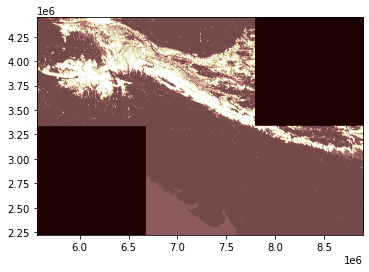

In [13]:
file1 = rasterio.open('H:/Avi_SCA/Data/marged_data/2000057.tif')
show(file1, cmap='pink')

# Reproject the dataset to ESPG:4326

In [20]:
mosaic_files = []

os.chdir("F:/Avi_SCA/Data/marged_data")
for file in glob.glob("*.tif"):
    mosaic_files.append(file)
len(mosaic_files)    

916

In [26]:
mosaic_files[815] 

'2017361.tif'

In [28]:
# all the mosaic files from the "marged_data" folder are reprojected to ESPG:4326 and stored in "reprjected_data" folder
dst_crs = 'EPSG:4326'
for files in mosaic_files:
    with rasterio.open('F:/Avi_SCA/Data/marged_data/'+files) as src:
        
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        with rasterio.open('F:/Avi_SCA/Data/reprjected_data/reprojected'+files[0:7]+'.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    

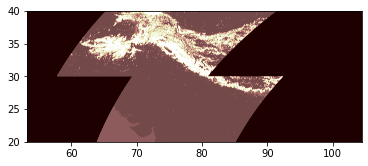

In [14]:
file1 = rasterio.open('H:/Avi_SCA/Data/reprjected_data/reprojected2000057.tif')
show(file1, cmap='pink')

# Clipping with the Shapefile

In [29]:
# study region: North West Himalayan (NWH) region
crop_extent = gpd.read_file('F:/Avi_SCA/Data/NWH_shapefile/NWH.shp')

In [30]:
reprojected_files = []

os.chdir("F:/Avi_SCA/Data/reprjected_data")
for file in glob.glob("*.tif"):
    reprojected_files.append(file)
reprojected_files[1][11:18]

'2000065'

In [31]:
# reprojected observations are cliped according to the shapefile's maximum extent and saved in "clilpped_square" folder
for files in reprojected_files:
    open_file = rasterio.open('F:/Avi_SCA/Data/reprjected_data/'+files)
    mosaic_crop, mosaic_crop_meta = es.crop_image(open_file,crop_extent)
    #mosaic_crop_affine = mosaic_crop_meta["transform"]
    #mosaic_crop_extent = plotting_extent(mosaic_crop[0], mosaic_crop_affine)
    with rasterio.open('F:/Avi_SCA/Data/clilpped_square/clipped_square'+files[11:18]+'.tif', 'w', **mosaic_crop_meta) as dst:
        dst.write(mosaic_crop)

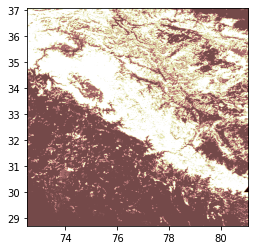

In [32]:
file1 = rasterio.open('F:/Avi_SCA/Data/clilpped_square/clipped_square2019001.tif')
show(file1, cmap='pink')

In [33]:
clipped_square_files = []

os.chdir("F:/Avi_SCA/Data/clilpped_square")
for file in glob.glob("*.tif"):
    clipped_square_files.append(file)
clipped_square_files[1][14:21]

'2000065'

In [34]:
# cliped with the shapefile,area outside the shapefile is masked, and stored in "clipped_nwh" folder
for files in clipped_square_files:
    with rasterio.open("F:/Avi_SCA/Data/clilpped_square/"+files) as src:
        out_image, out_transform = rasterio.mask.mask(src, crop_extent.geometry, crop=True)
        out_meta = src.meta
    with rasterio.open('F:/Avi_SCA/Data/clipped_nwh/nwh'+files[14:21]+'.tif', "w", **out_meta) as dest:
        dest.write(out_image)    

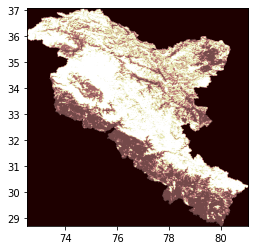

In [78]:
file1 = rasterio.open('F:/Avi_SCA/Data/test_2019/clipped_nwh/nwh2019001.tif')
show(file1, cmap='pink')

## Preparation of monthly maximum snow cover extent of NWH region

In [49]:
all_data = []

os.chdir("F:/Avi_SCA/Data/clipped_nwh")
for file in glob.glob("*.tif"):
    all_data.append(file)
all_data[-1]

'nwh2020057.tif'

In [40]:
all_data = all_data[0:80]
all_data [79]


'nwh2001345.tif'

In [50]:
# function to generate monthly maximum snow cover extent
def monthly_avg_SCA(filenames,start_year,end_year):
    count = start_year
    month_limit = 1
    month_count = 0
    days_end_mnt = [1, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
    monthly_data = []
    avg_monthly_sca = []
    while count<=end_year:
        while month_limit <365:
            for item in filenames:
                if int(item[3:7])==count:
                    if days_end_mnt[month_count]<=int(item[7:10])<=days_end_mnt[month_count+1]:
                        monthly_sca = rasterio.open('F:/Avi_SCA/Data/clipped_nwh/'+item)
                        
                        monthly_sca_array = monthly_sca.read(1)
                        only_snow = monthly_sca_array==200
                        only_snow_array= np.array(only_snow)
                        monthly_data.append(only_snow_array)
            if len(monthly_data)>=2:
                #masked_monthly_data = ma.masked_where(monthly_data != 200, monthly_data)
                #monthly_data_array = np.array(masked_monthly_data)    
                avg_monthly_data = np.mean(monthly_data, axis=0)
                snow_non_snow = avg_monthly_data>0
                avg_monthly_sca.append(snow_non_snow)
                            
            

        
            monthly_data = []
            month_count = month_count+1
            month_limit = days_end_mnt[month_count]
            
            
        count = count + 1
        monthly_data =[]
        month_count = 0
        month_limit = 1
    return np.array(avg_monthly_sca)

In [51]:
snow = monthly_avg_SCA(all_data,2000,2020)

In [52]:
snow.shape

(240, 2571, 2614)

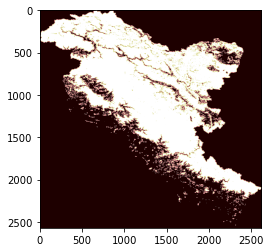

In [56]:
show(snow[11], cmap='pink')

In [57]:
sample = rasterio.open('F:/Avi_SCA/Data/clipped_nwh/'+all_data[0])
profile=sample.profile
os.chdir("F:/Avi_SCA/Data/monthly_SCA")
count=3
items = 0
while items < len(snow):
    with rasterio.open('nwh_sca_%s.tif'%(str(count).zfill(3),), 'w', **profile) as dst:
        dst.write(snow[items].astype(rasterio.uint8), indexes=1)
    items = items + 1
    count=count +1

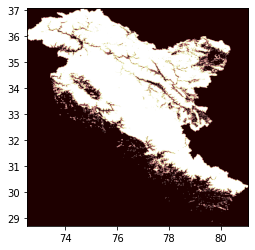

In [60]:
sample1 = rasterio.open('F:/Avi_SCA/Data/monthly_SCA/nwh_sca_003.tif')
show(sample1, cmap='pink')